# 激活函数

我们一直着眼于人工神经元网络模型的线性回归部分，忽略了激活函数部分。理论上，如果只是线性回归的话，无论多少层的网络模型仍然还是线性变换，并不会和单层网络模型有本质的差别。这也正是我们在上一个章节观察到的现象。

线性回归部分表达的是人工神经元模型数据汇总的能力。激活函数部分才真正决定数据以什么样的形式继续向下一层传播。

激活函数的本质是对线性回归的结果进行一次非线性变换，从而赋予人工神经元更大的可能性。

<div style="border-left: 4px solid #4CAF50; background:#f9f9f9; padding:10px; margin:10px 0;">
<strong>💡 通用近似定理：</strong> 数学证明，只要拥有足够多的隐藏层神经元和至少一个非线性激活函数，神经元网络可以以任意精度拟合任何连续函数。这就是为什么深度学习能够处理图像、声音和文字等极其复杂的非线性数据。
</div>

In [5]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(99)

## 数据集

### 训练数据：特征、标签

In [6]:
train_features = np.array([[22.5, 72.0],
                           [31.4, 45.0],
                           [19.8, 85.0],
                           [27.6, 63]])

train_labels = np.array([[95],
                        [210],
                        [70],
                        [155]])

### 测试数据：特征、标签

In [7]:
test_features = np.array([[28.1, 58.0]])
test_labels = np.array([[165]])

## 模型

### 参数：隐藏层权重、偏置

In [8]:
hidden_weight = np.random.rand(4, 2) / 2
hidden_bias = np.random.rand(4)

### 参数：输出层权重、偏置

In [9]:
output_weight = np.random.rand(1, 4) / 4
output_bias = np.random.rand(1)

### 推理函数

In [10]:
def forward(x, w, b):
    return x @ w.T + b

### ReLU激活函数

线性整流函数ReLU（Rectified Linear Unit）是目前最常用的隐藏层激活函数。它的逻辑非常简单：负数归零。这是它的公式：

$$
f(x) = \max(0, x)
$$

ReLU激活函数优点非常明显：

* 逻辑简单，运算飞快。
* 过滤掉所有负数。可以理解为过滤掉所有不重要的信息，或者噪音。
* 所有正数保持不变，在正数区间的导数恒为1。因此不会减弱有效信息，导致梯度消失。这对于训练深层网络至关重要。

In [11]:
def relu(x):
    return np.maximum(0, x)

我们看一下ReLU激活函数的效果：

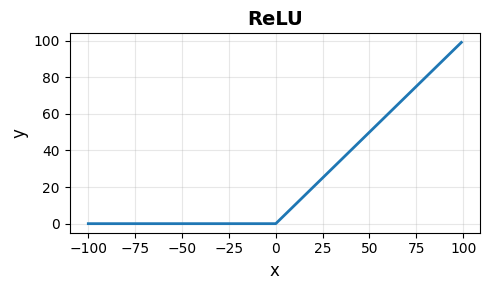

In [30]:
plt.figure(figsize=(5, 3))
plt.plot(range(-100, 100), [relu(x) for x in range(-100, 100)], linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('ReLU', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 损失函数（平均平方差）

In [13]:
def mse_loss(p, y):
    return np.mean(np.square(y - p))

### 梯度函数

In [14]:
def gradient(p, y):
    return - 2 * (y - p) / len(y)

### 反向函数

In [15]:
def backward(x, d, w, b, lr):
    w = w - d.T @ x * lr
    b = b - np.sum(d, axis=0) * lr
    return w, b

### 梯度反向函数

In [16]:
def gradient_backward(d, w):
    return d @ w / len(d)

### ReLU反向激活函数

随着ReLU激活函数加入前向传播链，梯度计算的过程中也需要加入ReLU反向函数，即ReLU激活函数的偏导数。

In [17]:
def relu_backward(p, d):
    return (p > 0) * d

## 训练

### 超参数：学习率

In [18]:
LEARNING_RATE = 0.00001

### 超参数：批大小

In [19]:
BATCH_SIZE = 2

### 超参数：轮数

In [20]:
EPOCHS = 1000

### 迭代

数据在前向传播的过程中经过的所有计算步骤（包括激活函数），在梯度计算的过程中都需要以相反的次序，依次经过对应的反向函数。

* 前向传播：ReLU激活函数在隐藏层前向传播的最后，相当于消除中间值的噪音（负数）。目的在于强化向下一层传播的信号。

```{figure} images/layer-relu-forward.png
:align: center
:width: 520px

* x：特征值
* w<sub>1</sub>, b<sub>1</sub>：隐藏层权重偏置
* h：中间值
* w<sub>2</sub>, b<sub>2</sub>：输出层权重偏置
* p：预测值
```

* 梯度计算：ReLU反向激活函数在隐藏层梯度计算之后，相当于过滤掉所有中间值噪音（负数）的梯度。目的在于终止这些噪音的训练。

```{figure} images/layer-relu-gradient.png
:align: center
:width: 680px

* p：预测值
* y：标签值
* e：损失值
* d<sub>2</sub>：输出层误差项
* w<sub>2</sub>：输出层权重
* h：中间值
* d<sub>1</sub>：隐藏层误差项
```

现在，让我们把ReLU激活函数用到隐藏层之后，看看会有什么样的效果。同时，也要记得在梯度计算的合适位置使用ReLU反向激活函数。

<div style="border-left: 4px solid #4CAF50; background:#f9f9f9; padding:10px; margin:10px 0;">
<strong>💡 提示：</strong> 通常在数值回归类型的模型中，输出层后面不需要激活函数。后续我们会看到，在分类模型中，输出层后面也会使用激活函数来辅助决策。
</div>

In [21]:
for epoch in range(EPOCHS):
    for i in range(0, len(train_features), BATCH_SIZE):
        features = train_features[i: i + BATCH_SIZE]
        labels = train_labels[i: i + BATCH_SIZE]

        # 隐藏层前向传播之后，使用ReLU激活函数
        hidden = relu(forward(features, hidden_weight, hidden_bias))
        # 输出层前向传播
        predictions = forward(hidden, output_weight, output_bias)
        # 输出层梯度计算
        output_delta = gradient(predictions, labels)
        # 隐藏层梯度计算之后，使用ReLU反向函数
        hidden_delta = relu_backward(hidden, gradient_backward(output_delta, output_weight))
        # 输出层反向传播
        output_weight, output_bias = backward(hidden, output_delta, output_weight, output_bias, LEARNING_RATE)
        # 隐藏层反向传播
        hidden_weight, hidden_bias = backward(features, hidden_delta, hidden_weight, hidden_bias, LEARNING_RATE)

print(f"hidden weight: {hidden_weight}")
print(f"hidden bias: {hidden_bias}")
print(f"output weight: {output_weight}")
print(f"output bias: {output_bias}")

hidden weight: [[ 1.25334868 -0.12494105]
 [ 1.22181158 -0.3812745 ]
 [ 1.67848131 -0.18041878]
 [ 0.57117996 -0.13634797]]
hidden bias: [1.0070986  0.02090477 0.79305387 0.75439973]
output weight: [[1.70005368 1.70760857 2.3005622  0.8162836 ]]
output bias: [1.02040597]


## 验证

### 推理

In [22]:
hidden = relu(forward(test_features, hidden_weight, hidden_bias))
predictions = forward(hidden, output_weight, output_bias)
print(f'predictions: {predictions}')

predictions: [[164.70769666]]


### 评估

In [23]:
error = mse_loss(predictions, test_labels)
print(f'error: {error}')

error: 0.08544124183851694


神奇的效果！

在上一个章节里，我们观察到两层网络模型虽然可行，但是并没有表现得比单层网络模型更出色，甚至有所减弱。

但是在我们使用了隐藏层激活函数后，效果大增到损失值几乎为0的程度。这表明我们的网络模型几乎完美地拟合了训练数据，同时在测试数据上也表现出优秀的泛化能力。